# Global Diferential Privacy Assessement: NeuroImaging

This is the final version of showcasing how our Global Differential Privacy can guaranty privacy when analyzing and sharing data.
After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy in the term of real-world Bids-like neuroimages.
- Apply Global Differential Privacy to images.

In [3]:
import os, sys, subprocess, wget, shutil, mne, warnings
import pandas as pd
import numpy as np
from scipy.io import loadmat

warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

We download an image from a real study and prepare it to assess.

In [2]:
script = os.path.join(os.path.dirname(os.getcwd())+"/CalibrateNoise/", "main.py") 
file = "input/anat/original/"
clean = False

os.makedirs("img", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004934/sub-SAXNES2s001/func/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz?versionId=R0fwRS9fxw8CcPZnb4zYsw9I5v19aAbP"
wget.download(link_original)
os.makedirs(file, exist_ok=True)
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file.endswith(".gz")]
shutil.copy2(file_[0], file)
os.remove(file_[0])
print(f"\nOriginal file downloaded.") 


100% [....................................................] 60545196 / 60545196
Original file downloaded.


In [5]:
result = subprocess.run(
    ["python3", script, file],
    capture_output=True,
    text=True
)
print(result.stdout)
if clean:
    ! rm -r input
    print(f"Cleaning up finished")  

========== ERN ==========

Total time taken: 00:01:03



# Related update from 16/09

# Data import and concatenating frames for MEEG
data in are 2D -- channels x frames
assemble per subjects -- channels x frames x subjects

to concatenate and estinate covariance --> channels x [subjects *frames]

ie repeat N subjects over frames (not all frames per subjects and subjects after each other)


# Cyril's mail

n 22 is the number of clusters -- but we decided to NOT use clusters because the labelling makes no sense

make a channel x channel dp noise matrix

for each channel, read upper triangle to find neighbourgh and compute dp, store results say in dimension 2

once all channels have been iterated, average covariance values resulting in channel noise vector 

### Finding neighbors based on limo-AvgChanlocs.mat

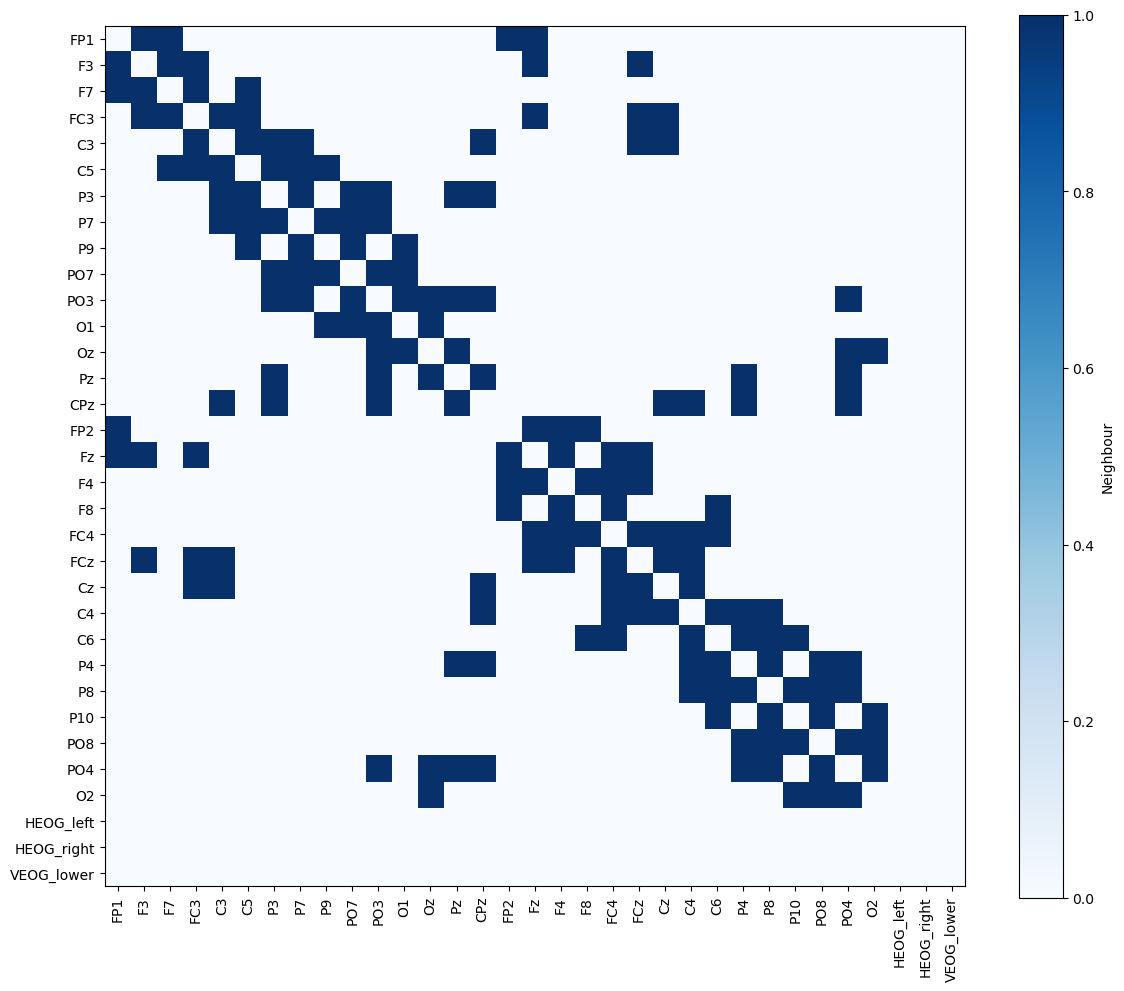

In [270]:

raw = mne.io.read_raw_brainvision(vhdr_file, preload=False)
ch_names = raw.ch_names
mat = loadmat("limo-AvgChanlocs.mat")
avg_chanlocs = mat["AvgChanlocs"]
chanlocs_struct = avg_chanlocs['expected_chanlocs'].item()
labels_raw = chanlocs_struct['labels'].squeeze()
mat_labels = [str(lbl[0]) if isinstance(lbl, np.ndarray) else str(lbl) for lbl in labels_raw]
neighb_mat = np.array(avg_chanlocs['channeighbstructmat'].item(), dtype=int)
label_to_idx = {lab: i for i, lab in enumerate(mat_labels)}

aligned_neighb = np.zeros((len(ch_names), len(ch_names)), dtype=int)
for i, ch_i in enumerate(ch_names):
    if ch_i in label_to_idx:
        for j, ch_j in enumerate(ch_names):
            if ch_j in label_to_idx:
                aligned_neighb[i, j] = neighb_mat[label_to_idx[ch_i], label_to_idx[ch_j]]

plt.figure(figsize=(12, 10))
plt.imshow(aligned_neighb, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Neighbour")
plt.xticks(ticks=np.arange(len(ch_names)), labels=ch_names, rotation=90)
plt.yticks(ticks=np.arange(len(ch_names)), labels=ch_names)

plt.tight_layout()
plt.savefig("neighbors'mat.png")
plt.show()



In [263]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

vhdr_file = "/staff/vincentajoubi/Trash/wp15-chrono-T/usecase-2.4/input/sub-032/ses-ERN/eeg/sub-032_ses-ERN_task-ERN_eeg.vhdr"

raw = mne.io.read_raw_brainvision(vhdr_file, preload=False)
ch_names = raw.ch_names
mat = loadmat("limo-AvgChanlocs.mat")
avg_chanlocs = mat["AvgChanlocs"]
chanlocs_struct = avg_chanlocs['expected_chanlocs'].item()
labels_raw = chanlocs_struct['labels'].squeeze()
mat_labels = [str(lbl[0]) if isinstance(lbl, np.ndarray) else str(lbl) for lbl in labels_raw]
neighb_mat = np.array(avg_chanlocs['channeighbstructmat'].item(), dtype=int)
label_to_idx = {lab: i for i, lab in enumerate(mat_labels)}
channel_neighbours = {}
for ch in ch_names:
    if ch in label_to_idx:
        idx = label_to_idx[ch]
        neigh_idx = np.where(neighb_mat[idx] == 1)[0]
        neigh_labels = [mat_labels[n] for n in neigh_idx]
        channel_neighbours[ch] = neigh_labels
    else:
        channel_neighbours[ch] = []

channel_neighbours

{'FP1': ['F3', 'F7', 'FP2', 'Fz'],
 'F3': ['FP1', 'F7', 'FC3', 'Fz', 'FCz'],
 'F7': ['FP1', 'F3', 'FC3', 'C5'],
 'FC3': ['F3', 'F7', 'C3', 'C5', 'Fz', 'FCz', 'Cz'],
 'C3': ['FC3', 'C5', 'P3', 'P7', 'CPz', 'FCz', 'Cz'],
 'C5': ['F7', 'FC3', 'C3', 'P3', 'P7', 'P9'],
 'P3': ['C3', 'C5', 'P7', 'PO7', 'PO3', 'Pz', 'CPz'],
 'P7': ['C3', 'C5', 'P3', 'P9', 'PO7', 'PO3'],
 'P9': ['C5', 'P7', 'PO7', 'O1'],
 'PO7': ['P3', 'P7', 'P9', 'PO3', 'O1'],
 'PO3': ['P3', 'P7', 'PO7', 'O1', 'Oz', 'Pz', 'CPz', 'PO4'],
 'O1': ['P9', 'PO7', 'PO3', 'Oz'],
 'Oz': ['PO3', 'O1', 'Pz', 'PO4', 'O2'],
 'Pz': ['P3', 'PO3', 'Oz', 'CPz', 'P4', 'PO4'],
 'CPz': ['C3', 'P3', 'PO3', 'Pz', 'Cz', 'C4', 'P4', 'PO4'],
 'FP2': ['FP1', 'Fz', 'F4', 'F8'],
 'Fz': ['FP1', 'F3', 'FC3', 'FP2', 'F4', 'FC4', 'FCz'],
 'F4': ['FP2', 'Fz', 'F8', 'FC4', 'FCz'],
 'F8': ['FP2', 'F4', 'FC4', 'C6'],
 'FC4': ['Fz', 'F4', 'F8', 'FCz', 'Cz', 'C4', 'C6'],
 'FCz': ['F3', 'FC3', 'C3', 'Fz', 'F4', 'FC4', 'Cz', 'C4'],
 'Cz': ['FC3', 'C3', 'CPz', 'FC4'

In [10]:
from src.loader import fetch_files

all_results = []

avg_chanlocs = loadmat("limo-AvgChanlocs.mat")["AvgChanlocs"]
chanlocs_struct = avg_chanlocs['expected_chanlocs'].item()
labels_raw = chanlocs_struct['labels'].squeeze()
mat_labels = [str(lbl[0]) if isinstance(lbl, np.ndarray) else str(lbl) for lbl in labels_raw]
neighb_mat = np.array(avg_chanlocs['channeighbstructmat'].item(), dtype=int)
label_to_idx = {lab: i for i, lab in enumerate(mat_labels)}

tasks = ["ERN","LRP","MMN","N2pc","N170","N400","P3"]
task_order = {task: idx for idx, task in enumerate(tasks)}
def task_(path):
    for task in tasks:
        if f"_task-{task}_" in path or f"/ses-{task}/" in path:
            return task
    return None 

path = "/staff/vincentajoubi/Trash/wp15-chrono-T/usecase-2.4/input/"
path_list = fetch_files(path).vhdr_()
path_list_sorted = sorted(path_list, key=lambda x: task_order.get(task_(x), float('inf')))
path_list_sorted = [[path for path in path_list_sorted if task in path] for task in tasks] # each index refers to a task for all subjects

for path_list in path_list_sorted:
    for path in path_list:
        try:
            raw = mne.io.read_raw_brainvision(path, preload=True)  
            eeg_data = raw.get_data()  
            channel_data_dict = {ch: eeg_data[i] for i, ch in enumerate(raw.ch_names)}
    
            cn_data = {}
            for ch in raw.ch_names:
                if ch in label_to_idx:
                    idx = label_to_idx[ch]
                    neigh_idx = np.where(neighb_mat[idx] == 1)[0]
                    neighbor_labels = [mat_labels[n] for n in neigh_idx if mat_labels[n] in raw.ch_names]
                    
                    neighbor_data_dict = {}
                    for neighbor in neighbor_labels:
                        if neighbor in channel_data_dict:
                            neighbor_data_dict[neighbor] = channel_data_dict[neighbor]
                    
                    cn_data[ch] = neighbor_data_dict
                else:
                    cn_data[ch] = {}
    
            file_result = {
                'filename': path,
                'raw_data': eeg_data,
                'channel_data_dict': channel_data_dict,
                'cn_data': cn_data,
                'channel_names': raw.ch_names,
                'n_channels': len(raw.ch_names),
                'n_samples': eeg_data.shape[1]
            }
            
            all_results.append(file_result)
            
        except Exception as e:
            print(f"Error processing {vhdr_file}: {e}")
            continue
    break    
    
results_ = np.array(all_results, dtype=object)


In [196]:
all_subj_data = list()

for subject in range(len(results_)):
    g = dict()
    for cluster in list(results_[subject]["cn_data"].keys()):
        c=dict()
        for neigh in results_[subject]["cn_data"][cluster]:
            c[neigh] = results_[subject]["cn_data"][cluster][neigh]  
        g[cluster] = c
    all_subj_data.append(g)

#[cluster.shape for subj in all_subj_data for cluster in subj]

In [262]:
cluster = [c for c in all_subj_data[0]]
for c in cluster:
    raw_c = list()
    max_ = int()
    for subject in range(len(results_)):
        raw = np.array([t for t in all_subj_data[subject][c].values()]) # 'FP1': ['F3', 'F7', 'FP2', 'Fz']
        max_ = np.max([t.shape for t in all_subj_data[subject][c].values()])
        print(subject, c, list(all_subj_data[subject][c].keys()))    
        raw_c.append(raw)
    #for time in range(max_):
    #    final_raw_data = np.vstack([s[:, time] for s in raw_c])
    #    print(final_raw_data[0])
    break
    print("*"*30)
    

0 FP1 ['F3', 'F7', 'FP2', 'Fz']
1 FP1 ['F3', 'F7', 'FP2', 'Fz']
2 FP1 ['F3', 'F7', 'FP2', 'Fz']
3 FP1 ['F3', 'F7', 'FP2', 'Fz']
4 FP1 ['F3', 'F7', 'FP2', 'Fz']
5 FP1 ['F3', 'F7', 'FP2', 'Fz']
6 FP1 ['F3', 'F7', 'FP2', 'Fz']
7 FP1 ['F3', 'F7', 'FP2', 'Fz']
8 FP1 ['F3', 'F7', 'FP2', 'Fz']
9 FP1 ['F3', 'F7', 'FP2', 'Fz']
10 FP1 ['F3', 'F7', 'FP2', 'Fz']
11 FP1 ['F3', 'F7', 'FP2', 'Fz']
12 FP1 ['F3', 'F7', 'FP2', 'Fz']
13 FP1 ['F3', 'F7', 'FP2', 'Fz']
14 FP1 ['F3', 'F7', 'FP2', 'Fz']
15 FP1 ['F3', 'F7', 'FP2', 'Fz']
16 FP1 ['F3', 'F7', 'FP2', 'Fz']
17 FP1 ['F3', 'F7', 'FP2', 'Fz']
18 FP1 ['F3', 'F7', 'FP2', 'Fz']
19 FP1 ['F3', 'F7', 'FP2', 'Fz']
20 FP1 ['F3', 'F7', 'FP2', 'Fz']
21 FP1 ['F3', 'F7', 'FP2', 'Fz']
22 FP1 ['F3', 'F7', 'FP2', 'Fz']
23 FP1 ['F3', 'F7', 'FP2', 'Fz']
24 FP1 ['F3', 'F7', 'FP2', 'Fz']
25 FP1 ['F3', 'F7', 'FP2', 'Fz']
26 FP1 ['F3', 'F7', 'FP2', 'Fz']
27 FP1 ['F3', 'F7', 'FP2', 'Fz']
28 FP1 ['F3', 'F7', 'FP2', 'Fz']
29 FP1 ['F3', 'F7', 'FP2', 'Fz']
30 FP1 ['F3', 'F7', 

4

In [ ]:
#I should have 39 subject
#each has 33 channels. the plan was an array of [39, 33, k]
#but now is                                      [39, [4-7], k]


In [ ]:

try:
    for time in range(np.max([subject.shape[1] for subject in all_values])):
        raw_data = np.vstack([subject[:, time] for subject in all_values]).T
        
        original_output = user_pipeline(raw_data)
        noisy_outputs, sensitivities = dp(raw_data, original_output)
        
        
except IndexError: pass

Down here I'm loading just one task(ERN) for all subjects.

so at the end variable all_values has the shape 39 which refers to task ERN for each subject.


In [264]:
from src.loader import fetch_files
import mne
tasks = ["ERN","LRP","MMN","N2pc","N170","N400","P3"]
task_order = {task: idx for idx, task in enumerate(tasks)}
def task_(path):
    for task in tasks:
        if f"_task-{task}_" in path or f"/ses-{task}/" in path:
            return task
    return None 

path = "/staff/vincentajoubi/Trash/wp15-chrono-T/usecase-2.4/input/"
path_list = fetch_files(path).vhdr_()
path_list_sorted = sorted(path_list, key=lambda x: task_order.get(task_(x), float('inf')))
path_list_sorted = [[path for path in path_list_sorted if task in path] for task in tasks] # each index refers to a task for all subjects

all_values = list()
for path_list in path_list_sorted:
    for path in path_list:
        raw = mne.io.read_raw_brainvision(path, preload=True).get_data()
        all_values.append(raw)
    break

#test = np.empty(len(all_values), dtype=object)
#for i, arr in enumerate(all_values):
#    test[i] = arr

The visualization below shows one channel for each subject, where y-axis shows time or length of the channel. 

There 33 channels, so assume for each bar in the plot, it is extended by 33.

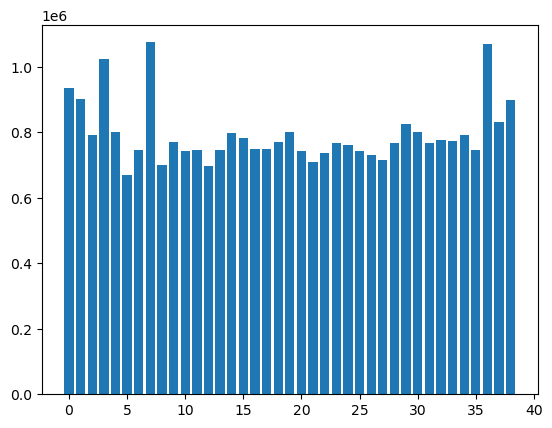

In [268]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(all_values))], [i.shape[1] for i in all_values])
plt.show()

Here I have taken time t of each subject in each channel and compute the covariance. So the data input to calculate cov is (39, 33) up until all subject has time t in common.

In [207]:
try:
    print(f"Max val along all channels: {np.max([subject.shape[1] for subject in all_values])}")
    for time in range(np.max([subject.shape[1] for subject in all_values])):
        if time % 100000 == 0:
            print(time, np.mean(np.cov(np.vstack([subject[:, time] for subject in all_values]))))
except IndexError: pass

Max val along all channels: 1074176
0 6647618.984755068
100000 7650665.771170235
200000 6433670.322630599
300000 6281892.719030941
400000 6715212.918483125
500000 6130087.805620784
600000 5902844.025179543


In [ ]:
# file:///users/vincentajoubi/Downloads/ERP%20CORE,%20All%20Files.pdf